In [32]:
import csv
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_trials = 10


In [44]:
n_val_trials = 1

model_names = [
         "icassp-convnet", "icassp-convnet_aug-all", 
         "icassp-ntt-convnet", "icassp-ntt-convnet_aug-all-but-noise", "icassp-ntt-convnet_aug-all",
         "pcen-convnet", "pcen-convnet_aug-all-but-noise", "pcen-convnet_aug-all",
         "icassp-add-convnet", "icassp-add-convnet_aug-all-but-noise", "icassp-add-convnet_aug-all",
         "pcen-add-convnet_aug-all-but-noise", "pcen-add-convnet_aug-all",
         "pcen-ntt-convnet_aug-all-but-noise", "pcen-ntt-convnet_aug-all"
]

n_models = len(model_names)
model_val_accs = np.zeros((n_models, 6))
model_test_accs = np.zeros((n_models, 6))
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)

    for test_unit_id in range(6):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)
        
        
        # TRIAL SELECTION
        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        trial_id = np.argmax(val_accs)

        
        # VALIDATION SET EVALUATION
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(test_unit_dir, trial_str)
        
        fns, fps, tns, tps = [], [], [], []
        validation_units = localmodule.fold_units()[test_unit_id][2]

        for val_unit_str in validation_units:
            predictions_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + val_unit_str,
                "clip-predictions.csv"
            ])
            prediction_path = os.path.join(
                trial_dir, predictions_name)

            # Load prediction.
            with open(prediction_path, 'r') as f:
                reader = csv.reader(f)
                rows = list(reader)
            rows = [",".join(row) for row in rows]
            rows = rows[1:]
            rows = "\n".join(rows)

            # Parse rows with correct header.
            df = pd.read_csv(StringIO(rows),
                names=[
                    "Dataset",
                    "Test unit",
                    "Prediction unit",
                    "Timestamp",
                    "Center Freq (Hz)",
                    "Augmentation",
                    "Key",
                    "Ground truth",
                    "Predicted probability"])
            y_pred = np.array(df["Predicted probability"])
            y_pred = (y_pred > 0.5).astype('int')

            # Load ground truth.
            y_true = np.array(df["Ground truth"])
            
            # Compute confusion matrix.
            tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
                y_true, y_pred).ravel()
            
            tns.append(tn)
            fps.append(fp)
            fns.append(fn)
            tps.append(tp)


        tn = sum(tns)
        tp = sum(tps)
        fn = sum(fns)
        fp = sum(fps)
        val_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_val_accs[model_id, test_unit_id] = val_acc

        
        # TEST SET EVALUATION
        trial_dir = os.path.join(
            test_unit_dir, trial_str)
        predictions_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "clip-predictions.csv"
        ])
        prediction_path = os.path.join(
            trial_dir, predictions_name)
        
        # Load prediction.
        with open(prediction_path, 'r') as f:
            reader = csv.reader(f)
            rows = list(reader)
        rows = [",".join(row) for row in rows]
        rows = rows[1:]
        rows = "\n".join(rows)

        # Parse rows with correct header.
        df = pd.read_csv(StringIO(rows),
            names=[
                "Dataset",
                "Test unit",
                "Prediction unit",
                "Timestamp",
                "Center Freq (Hz)",
                "Augmentation",
                "Key",
                "Ground truth",
                "Predicted probability"])
        y_pred = np.array(df["Predicted probability"])
        y_pred = (y_pred > 0.5).astype('int')

        # Load ground truth.
        y_true = np.array(df["Ground truth"])

        # Compute confusion matrix.
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
            y_true, y_pred).ravel()

        test_acc = 100 * (tn+tp) / (tn+tp+fn+fp)
        model_test_accs[model_id, test_unit_id] = test_acc

In [14]:
np.mean(model_val_accs, axis=1)

array([ 93.19314304,  93.84052689,  91.70716053,  94.08234303,
        94.9970139 ,  94.36204245,  95.05782743,  94.83430938,
        93.65937069,  94.63181743,  96.00080381,  95.72569854,
        95.25539963,  95.20631169,  94.55252615])

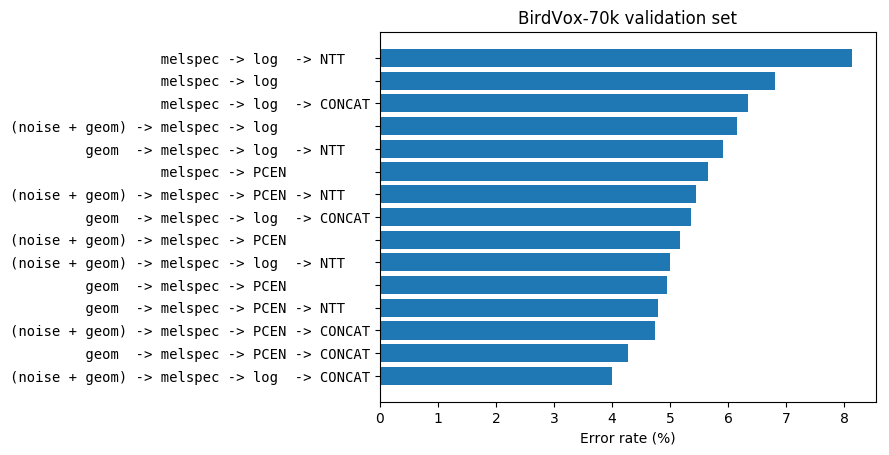

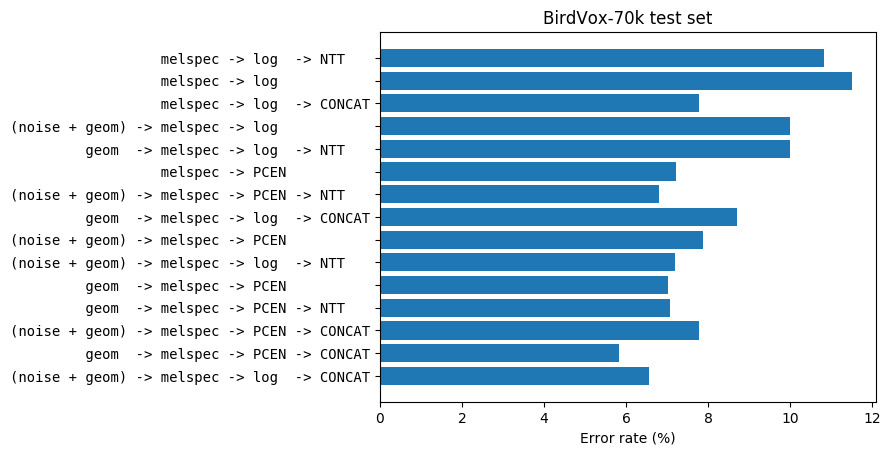

In [45]:
mean_val_accs = np.mean(model_val_accs, axis=1)
sorting_indices = np.argsort(mean_val_accs)
sorted_mean_val_accs = mean_val_accs[sorting_indices]

model_names = [
    "                  melspec -> log           ",
    "(noise + geom) -> melspec -> log           ",
    "                  melspec -> log  -> NTT   ",
    "         geom  -> melspec -> log  -> NTT   ",
    "(noise + geom) -> melspec -> log  -> NTT   ",
    "                  melspec -> PCEN          ",
    "         geom  -> melspec -> PCEN          ",
    "(noise + geom) -> melspec -> PCEN          ",
    "                  melspec -> log  -> CONCAT",
    "         geom  -> melspec -> log  -> CONCAT",
    "(noise + geom) -> melspec -> log  -> CONCAT",
    "         geom  -> melspec -> PCEN -> CONCAT",
    "(noise + geom) -> melspec -> PCEN -> CONCAT",
    "         geom  -> melspec -> PCEN -> NTT   ",
    "(noise + geom) -> melspec -> PCEN -> NTT   "]
sorted_model_names = [model_names[i] for i in sorting_indices]
mean_test_accs = np.mean(model_test_accs, axis=1)
sorted_mean_test_accs = mean_test_accs[sorting_indices]


plt.figure()
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(range(n_models), 100 - sorted_mean_val_accs)
ax.set_yticks(range(n_models))
ax.set_yticklabels(sorted_model_names)
plt.setp(ax.get_yticklabels(), family="monospace")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Error rate (%)')
ax.set_title('BirdVox-70k validation set')
plt.show()

plt.figure()
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(range(n_models), 100 - sorted_mean_test_accs)
ax.set_yticks(range(n_models))
ax.set_yticklabels(sorted_model_names)
plt.setp(ax.get_yticklabels(), family="monospace")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Error rate (%)')
ax.set_title('BirdVox-70k test set')
plt.show()

In [38]:
sorted_test_val_accs

array([ 88.49112057,  89.17692761,  90.00018514,  90.01930521,
        91.31050585,  92.13084219,  92.2322227 ,  92.23418659,
        92.79155628,  92.80251128,  92.9372463 ,  92.97560213,
        93.45440452,  94.18459338])

In [53]:
n_val_trials = 1
model_val_accs = np.zeros((11, 6))

model_names = [
    "pcen-add-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    "pcen-add-convnet",
    "pcen-ntt-convnet_aug-all",
    "pcen-ntt-convnet_aug-all-but-noise",
    "pcen-ntt-convnet"]
    
# Loop over models.
for model_id, model_name in enumerate(model_names):

    model_dir = os.path.join(models_dir, model_name)

    for test_unit_id in range(6):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        val_accs = []
        for trial_id in range(n_trials):
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            history_name = "_".join([
                dataset_name,
                model_name,
                test_unit_str,
                trial_str,
                "history.csv"
            ])
            history_path = os.path.join(
                trial_dir, history_name)
            try:
                history_df = pd.read_csv(history_path)
                val_acc = max(history_df["Validation accuracy (%)"])
            except:
                val_acc = 0.0
            val_accs.append(val_acc)

        val_accs = np.array(val_accs)
        best_trial_ids = np.argsort(val_accs)[::-1]
        best_trial_ids = best_trial_ids[:n_val_trials]

        for trial_id in best_trial_ids:

            trial_str = "trial-" + str(trial_id)
            fns, fps, tns, tps, accs = [], [], [], [], []
            validation_units = localmodule.fold_units()[test_unit_id][2]
            print(model_name, test_unit_str, trial_str)
            
    print("")

pcen-add-convnet_aug-all unit01 trial-9
pcen-add-convnet_aug-all unit02 trial-5
pcen-add-convnet_aug-all unit03 trial-5
pcen-add-convnet_aug-all unit05 trial-4
pcen-add-convnet_aug-all unit07 trial-0
pcen-add-convnet_aug-all unit10 trial-6

pcen-add-convnet_aug-all-but-noise unit01 trial-4
pcen-add-convnet_aug-all-but-noise unit02 trial-1
pcen-add-convnet_aug-all-but-noise unit03 trial-0
pcen-add-convnet_aug-all-but-noise unit05 trial-9
pcen-add-convnet_aug-all-but-noise unit07 trial-9
pcen-add-convnet_aug-all-but-noise unit10 trial-8

pcen-add-convnet unit01 trial-6
pcen-add-convnet unit02 trial-8
pcen-add-convnet unit03 trial-2
pcen-add-convnet unit05 trial-8
pcen-add-convnet unit07 trial-6
pcen-add-convnet unit10 trial-2

pcen-ntt-convnet_aug-all unit01 trial-9
pcen-ntt-convnet_aug-all unit02 trial-7
pcen-ntt-convnet_aug-all unit03 trial-8
pcen-ntt-convnet_aug-all unit05 trial-2
pcen-ntt-convnet_aug-all unit07 trial-2
pcen-ntt-convnet_aug-all unit10 trial-3

pcen-ntt-convnet_aug-all